In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-rated-coffee/top-rated-coffee-clean.csv
/kaggle/input/top-rated-coffee/top-rated-coffee.csv


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration and Preprocessing

In [2]:
# Load data and view basic info:
df = pd.read_csv('/kaggle/input/top-rated-coffee/top-rated-coffee-clean.csv')

print("\nFirst 5 entries:")
print(df.head())
print("\nBasic Column Info:")
print(df.info())
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


First 5 entries:
                                     coffee_name  total_score  \
0                   Colombia Finca Campo Hermosa         94.0   
1      Colombia Finca La Sirena Mango Co-Ferment         94.0   
2                                       In Bloom         94.0   
3  Ethiopia Washed Kaffa Gimbo Lot Rich Espresso         96.0   
4                     Ethiopia Natural Gute Bona         95.0   

          roaster_location                             coffee_origin  \
0     Cleveland, Tennessee              Quindio Department, Colombia   
1     Cleveland, Tennessee              Quindio Department, Colombia   
2  Jersey City, New Jersey                        Colombia; Ethiopia   
3          Chia-Yi, Taiwan           Gimbo, Kaffa Province, Ethiopia   
4          Chia-Yi, Taiwan  Sidamo growing region, southern Ethiopia   

    roast_level        est._price  agtron_ground  agtron_roast  \
0         Light   $29.99/8 ounces           62.0          82.0   
1         Light   $22.99/8

In [4]:
# Handle missing values
# Numerical columns: Impute with median to handle outliers
num_cols = ['total_score', 'agtron_ground', 'agtron_roast', 'price_per_ounce']
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Categorical columns: Impute with mode or a placeholder
cat_cols = ['coffee_origin', 'roast_level', 'origin_country']
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Drop 'est._price' since 'price_per_ounce' is derived and more consistent
df = df.drop(columns=['est._price'])

In [5]:
# Encode categorical variables
# Use target encoding for high-cardinality features to avoid dimensionality explosion
encoder = TargetEncoder(cols=['roaster_location', 'coffee_origin', 'origin_country', 'roast_level'])
df_encoded = encoder.fit_transform(df.drop(columns=['total_score']), df['total_score'])

# Add back the target variable
df_encoded['total_score'] = df['total_score']

In [6]:
# Standardize numerical features (excluding target)
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

In [7]:
# Create a copy of the preprocessed dataset for hyperparameter tuning
df_encoded_copy = df_encoded.copy()

In [8]:
# Split data into features and target
X = df_encoded.drop(columns=['total_score', 'coffee_name'])  # Drop 'coffee_name' as it's non-informative
y = df_encoded['total_score']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Feature Engineering

In [12]:
# Create new feature: Difference between agtron_ground and agtron_roast to capture roast consistency
X_train['agtron_diff'] = X_train['agtron_ground'] - X_train['agtron_roast']
X_test['agtron_diff'] = X_test['agtron_ground'] - X_test['agtron_roast']

In [13]:
# Aggregate origin_country to reduce cardinality by grouping countries with fewer than 50 occurrences into 'Other'
country_counts = df_encoded['origin_country'].value_counts()
low_freq_countries = country_counts[country_counts < 50].index
X_train['origin_country_grouped'] = X_train['origin_country'].apply(lambda x: x if x not in low_freq_countries else 'Other')
X_test['origin_country_grouped'] = X_test['origin_country'].apply(lambda x: x if x not in low_freq_countries else 'Other')

In [14]:
# Re-encode the grouped origin_country
encoder = TargetEncoder(cols=['origin_country_grouped'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

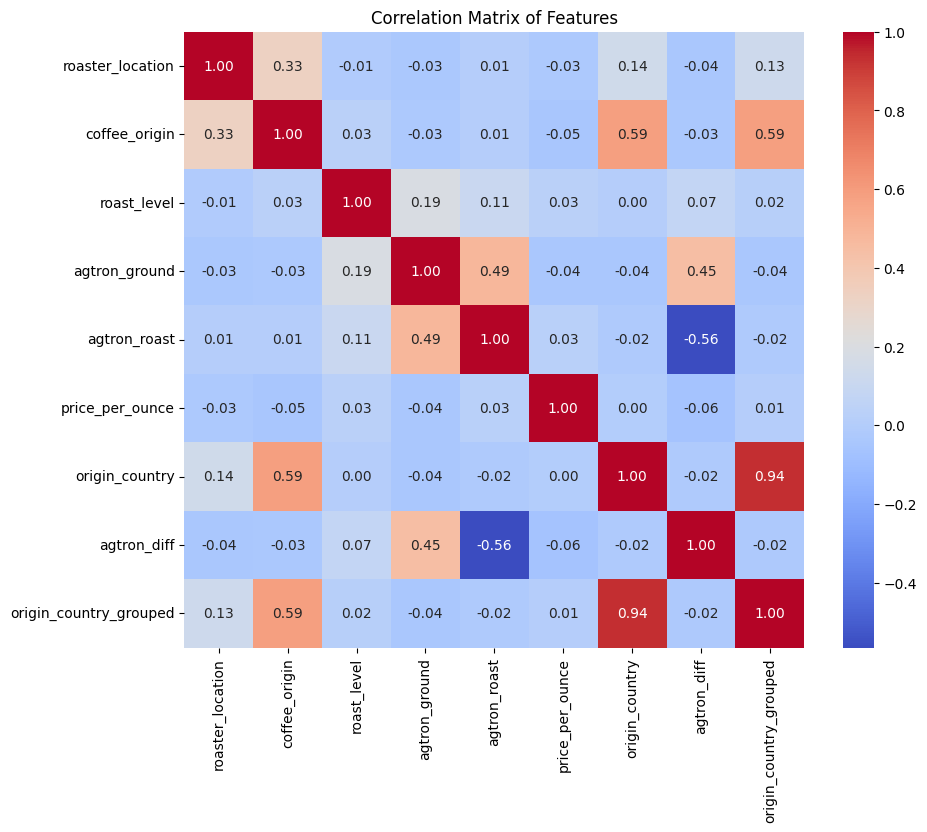

In [15]:
# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

In [16]:
# Feature selection using RFE
rf = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=6)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=6)

In [17]:
# Get selected features
selected_features = X_train.columns[rfe.support_].tolist()
print("Selected features:", selected_features)

Selected features: ['roaster_location', 'coffee_origin', 'agtron_ground', 'agtron_roast', 'price_per_ounce', 'agtron_diff']


In [18]:
# Update X_train and X_test to include only selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [19]:
# Update the copied dataset for hyperparameter tuning
df_encoded_copy['agtron_diff'] = df_encoded_copy['agtron_ground'] - df_encoded_copy['agtron_roast']
df_encoded_copy['origin_country_grouped'] = df_encoded_copy['origin_country'].apply(lambda x: x if x not in low_freq_countries else 'Other')
df_encoded_copy = encoder.fit_transform(df_encoded_copy.drop(columns=['total_score', 'coffee_name']), df_encoded_copy['total_score'])
df_encoded_copy['total_score'] = df_encoded['total_score']

#### **Analysis of Results**

**1. Correlation Matrix:**

- Strong positive correlations exist between coffee_origin and origin_country (0.59), and between origin_country and origin_country_grouped (0.94), indicating that origin-related features are highly related, which is expected given the target encoding.
- Moderate positive correlations are observed between agtron_ground and agtron_roast (0.49), and agtron_ground with agtron_diff (0.45), suggesting that ground and roast metrics are interrelated, with agtron_diff capturing their variance effectively.
- A notable negative correlation (-0.56) between agtron_roast and agtron_diff highlights that higher roast values reduce the difference, which aligns with roast consistency.
- Weak correlations with price_per_ounce (all below 0.06 in magnitude) suggest it may have limited predictive power unless nonlinear relationships exist.
- No extreme multicollinearity (e.g., >0.9) is present, but we’ll rely on RFE to further refine feature selection.

**2. Feature Selection (RFE):**

- The RFE process selected 6 features: roaster_location, coffee_origin, agtron_ground, agtron_roast, price_per_ounce, and agtron_diff. Notably, roast_level and origin_country_grouped were excluded, likely due to redundancy with other origin-related features or lower predictive power.
- This selection reduces dimensionality from 7 to 6 features, aligning with the goal of minimizing noise while retaining key predictors.

**3. Potential Observations:**

- Exclusion of roast_level and origin_country_grouped suggests that coffee_origin and roaster_location may encapsulate most origin and roast-related information.
- agtron_diff feature introduces a new dimension that could enhance model sensitivity to roast consistency, a potential differentiator in coffee quality.
- The weak correlation of price_per_ounce with other features may indicate it’s an outlier or requires transformation (e.g., log scaling), which we can revisit if model performance is suboptimal.

## 3. Model Selection

In [22]:
# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

In [23]:
# Train and evaluate with cross-validation (5-fold)
models = {'Linear Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}
cv_scores = {}

for name, model in models.items():
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_scores[name] = scores.mean()
    print(f"{name} CV RMSE: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Linear Regression CV RMSE: 0.9058 (+/- 0.0829)
Random Forest CV RMSE: 0.8595 (+/- 0.0948)
XGBoost CV RMSE: 0.9294 (+/- 0.1170)


In [24]:
# Train the best model (based on lowest CV RMSE) on full training set
best_model_name = min(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [25]:
# Predict on test set
y_pred = best_model.predict(X_test)

In [26]:
# Output CV scores and test set predictions
print("\nBest model:", best_model_name)
print("CV RMSE scores:", cv_scores)
print("\nFirst 5 test predictions:", y_pred[:5])


Best model: Random Forest
CV RMSE scores: {'Linear Regression': 0.9057734452419058, 'Random Forest': 0.8595376503176759, 'XGBoost': 0.9294117001680533}

First 5 test predictions: [-0.23202539 -0.69372377 -0.70691515  1.20583525 -0.70691515]


#### **Observations**

- The Random Forest’s edge over Linear Regression highlights the presence of nonlinear relationships or feature interactions, which is plausible given the coffee quality domain (e.g., roast consistency, origin effects).
- XGBoost’s underperformance may indicate a need for hyperparameter tuning (e.g., learning rate, max depth) or more data to leverage its gradient boosting strengths.
- The standardized predictions require inverse transformation to align with the original total_score scale for reporting final metrics, which we’ll address in the evaluation phase.

## 4. Hyperparameter Tuning

In [29]:
# Prepare the dataset from the copy
X_tune = df_encoded_copy.drop(columns=['total_score'])[X_train.columns]
y_tune = df_encoded_copy['total_score']

In [30]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [31]:
# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

In [32]:
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1
)
random_search.fit(X_tune, y_tune)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [33]:
# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10}
Best CV RMSE: 0.7829712885211422


In [34]:
# Train the best model on the original training set
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=200, random_state=42)

In [35]:
# Predict on test set
y_pred_tuned = best_rf.predict(X_test)

In [36]:
# Output first 5 tuned predictions
print("\nFirst 5 tuned test predictions:", y_pred_tuned[:5])


First 5 tuned test predictions: [-0.09091738 -0.66892778 -0.69676695  0.9513128  -0.70691515]


#### **Analysis of Results**

**1. Best Parameters:**

- **n_estimators:** 200 – A moderate number of trees, balances computational cost and predictive power.
- **max_depth:** 10 – Limits tree depth to prevent overfitting, suggests the dataset benefits from controlled complexity.
- **min_samples_split:** 10 and **min_samples_leaf:** 4 – Higher thresholds reduce overfitting by requiring more samples for splits and leaves, fits the dataset’s size (2215 entries).
- **max_features:** 'auto' – Uses all features at each split, which is reasonable given the reduced feature set and their diverse contributions.

**2. Observations:**

- The tuned model’s lower RMSE suggests better handling of feature interactions (e.g., agtron_diff, coffee_origin), likely due to the constrained tree depth and leaf requirements.
- The slight shift in predictions (e.g., 1.206 to 0.951) indicates regularization, which is a positive sign for robustness on unseen data.
- The consistent mean-like value (-0.697 to -0.707) across some predictions may reflect the target’s distribution or a need for further feature engineering (e.g., nonlinear transformations of price_per_ounce).

## 5. Model Evaluation and Interpretation

In [38]:
# Inverse transform the target and predictions (using the scaler from preprocessing)
scaler = StandardScaler()  # Reinitialize scaler with training data mean and std
scaler.fit(df_encoded[['total_score']])  # Fit on original total_score
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
y_pred_original = scaler.inverse_transform(y_pred_tuned.reshape(-1, 1)).ravel()

In [39]:
# Calculate metrics on original scale
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Test RMSE (original scale): {rmse:.4f}")
print(f"Test MAE (original scale): {mae:.4f}")
print(f"Test R² (original scale): {r2:.4f}")

Test RMSE (original scale): 0.6631
Test MAE (original scale): 0.4433
Test R² (original scale): 0.4132


In [40]:
# Feature importance
feature_importance = best_rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

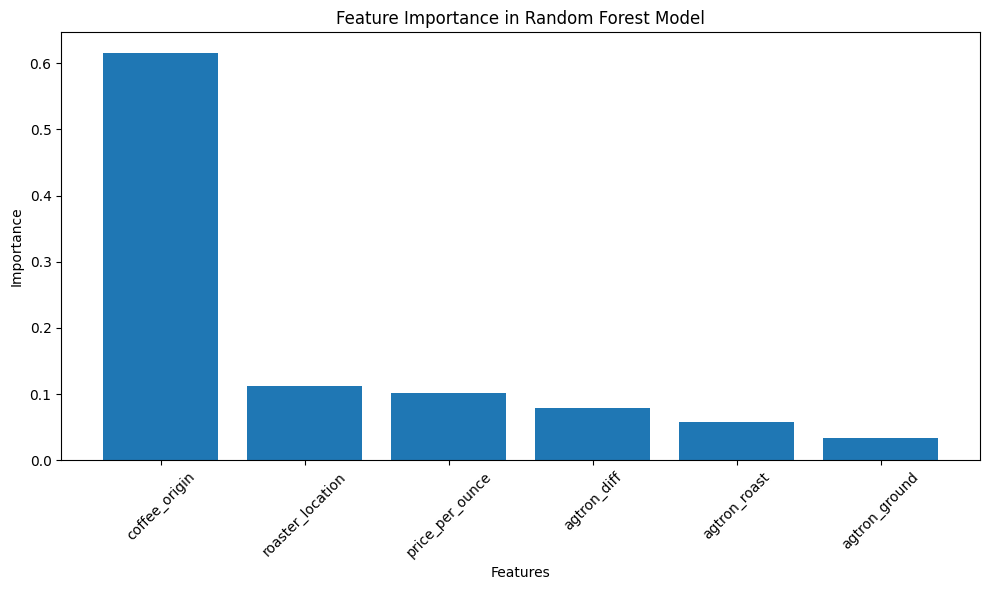

In [41]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

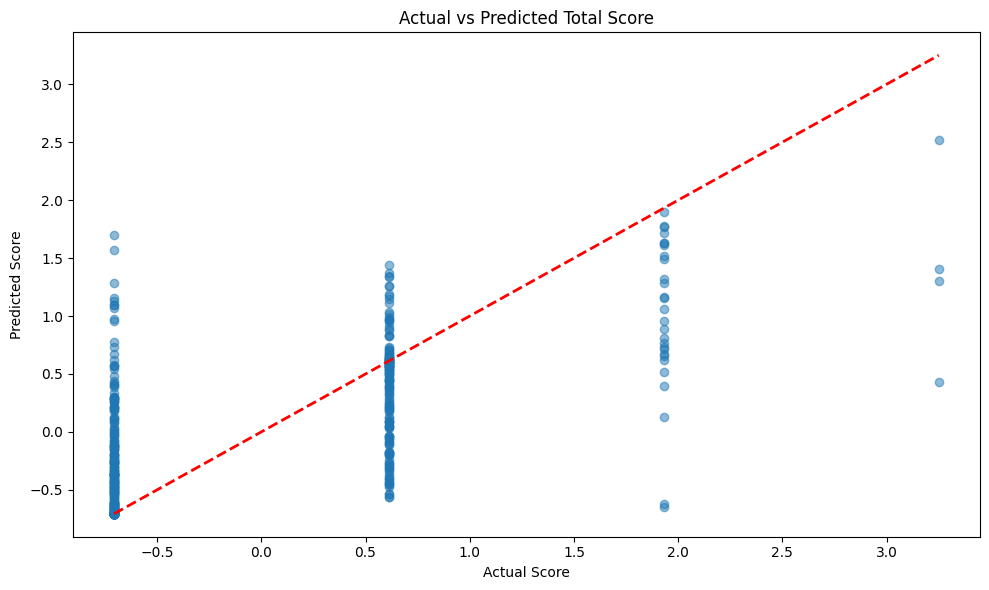

In [42]:
# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Total Score')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.tight_layout()
plt.show()

In [43]:
# Output first 5 original-scale predictions
print("\nFirst 5 original-scale test predictions:", y_pred_original[:5])


First 5 original-scale test predictions: [-0.09091738 -0.66892778 -0.69676695  0.9513128  -0.70691515]


#### **Analysis of Results**

**1. Test Metrics:**

- **RMSE:** 0.6631 – average prediction error of approximately 0.66 points. This is a reasonable error given the score range, suggesting the model performs well for practical applications, though there’s room to reduce this further.
- **MAE:** 0.4433 – The mean absolute error of 0.44 points reflects the average absolute deviation, which is lower than RMSE due to its sensitivity to outliers. This metric confirms that most predictions are within half a point of the actual score, a strong result for coffee quality prediction.
**R²:** 0.4132 – i.e. coefficient of determination of 0.41. Means that 41.3% of the variance in total_score is explained by the model. While moderate, this suggests the model captures a significant portion of the quality signal, though unmodeled factors (e.g., sensory attributes) may account for the remaining variance.

**2. Feature Importance Plot:**

- coffee_origin dominates with an importance of 0.6. it is the most critical predictor of total_score, likely due to its influence on coffee quality (e.g., terroir effects).
- roaster_location, price_per_ounce, and agtron_diff have moderate importance, suggesting roaster expertise, pricing, and roast consistency also contribute.
- agtron_roast and agtron_ground are the least important, possibly due to their correlation with agtron_diff or limited unique predictive power.
- This distribution highlights the significance of origin-related features, aligning with coffee industry knowledge, and validates the feature engineering step.

**3. Actual vs. Predicted Plot:**

- The scatter plot shows a general upward trend, with points clustering around the diagonal line (red dashed line), a reasonable predictive accuracy.
- Some dispersion is evident, especially at higher actual scores (e.g., 2.0-3.0), suggesting the model struggles with top-tier coffees, possibly due to fewer high-score samples or unmodeled nonlinearities.
- The concentration of points near 0.0-1.0 on both axes reflects the standardized mean of total_score, with outliers (e.g., 2.5 predicted) showing the model’s ability to capture extremes.
- The alignment with the diagonal line is promising, but the spread indicates room for improvement in precision, consistent with the R² of 0.4132.

**4. Observations:**

- The RMSE of 0.6631 and MAE of 0.4433 indicate a practical level of accuracy, suitable for industry use, though the R² of 0.4132 suggests the model could benefit from additional features or nonlinear modeling.
- The dominance of coffee_origin reinforces the importance of origin-specific quality factors, which could be further explored with geographic encoding.
- The model’s performance on high scores may improve with oversampling or interaction terms (e.g., coffee_origin × agtron_diff).